In [71]:
import numpy as np
import forward.common as common
import forward.homogeneous_semi_inf as semi_inf
import forward.homogeneous_inf_slab as slab
import utils.noise as noise
import matplotlib.pyplot as plt


# Generate some curves

In [72]:
tau = np.load("tau.npz")["tau_hardware"]
lambda0 = 785
mua = 0.01
musp = 10
rho = 2
n = 1.4
db = [1e-9, 2e-9, 5e-9, 1e-8, 2e-8, 5e-8]
beta = 0.5

Let's see how many terms are needed for the summation in the g1_transmittance function to converge.

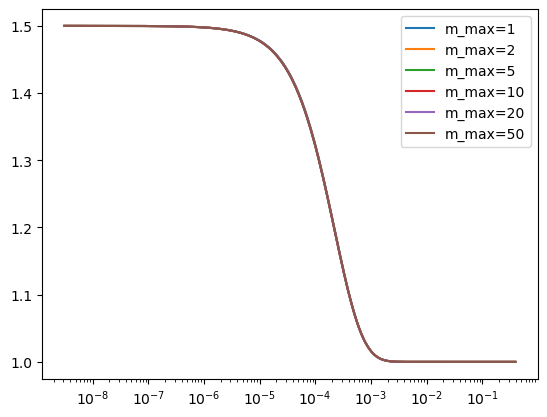

In [107]:
m_max = [1, 2, 5, 10, 20, 50]
msd = common.msd_brownian(tau, db[0])
plt.figure()
for m_max_ in m_max:
    g1_norm_semi_inf = slab.g1_transmittance_norm(msd, mua, musp, 0, n, lambda0, d=rho, m_max=m_max_)
    g2_norm_semi_inf = 1 + beta * g1_norm_semi_inf ** 2
    plt.semilogx(tau, g2_norm_semi_inf, label=f"m_max={m_max_}")

plt.legend()
plt.show()

Let's compare the g2 curves for the semi-infinite and slab geometries.

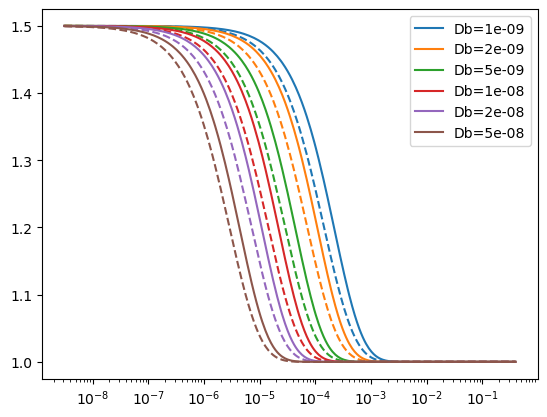

In [113]:
g1_norm_semi_inf = np.zeros((len(tau), len(db)))
g1_norm_slab = np.zeros((len(tau), len(db)))

for i in range(len(db)):
    msd = common.msd_brownian(tau, db[i])
    g1_norm_semi_inf[:, i] = slab.g1_transmittance_norm(msd, mua, musp, 0, n, lambda0, d=rho, m_max=10)
    g1_norm_slab[:, i] = semi_inf.g1_norm(msd, mua, musp, rho, n, lambda0)

g2_norm_semi_inf = 1 + beta * g1_norm_semi_inf ** 2
g2_norm_slab = 1 + beta * g1_norm_slab ** 2
# Use the same color for the same db value
plt.figure()
for i in range(len(db)):
    plt.semilogx(tau, g2_norm_semi_inf[:, i], label=f"Db={db[i]}", color=f"C{i}")
    plt.semilogx(tau, g2_norm_slab[:, i], linestyle='--', color=f"C{i}")
plt.legend()
plt.show()

# Add noise

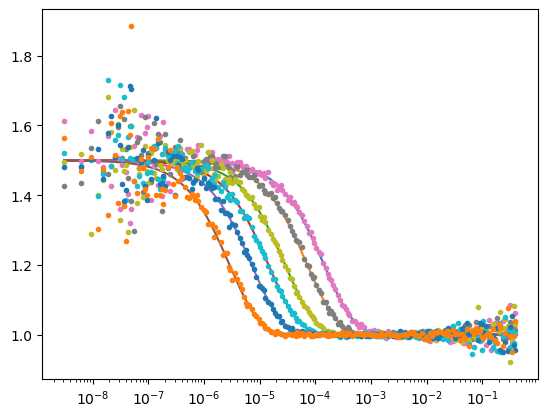

In [114]:
noise_adder = noise.NoiseAdder(
    g2_norm=g2_norm_slab,
    tau=tau,
    t_integration=1,
    countrate=100e3,
    beta=0.5,
    n_speckle=4,
    mua=mua,
    musp=musp,
    db=np.array(db),
    lambda0=lambda0
)

g2_norm_noisy = noise_adder.add_noise()
plt.semilogx(tau, g2_norm_slab)
plt.semilogx(tau, g2_norm_noisy, linestyle='none', marker='.')
plt.show()

In [ ]:
#beta_calculator =  fhsi.BetaCalculator(mode="fixed", beta_fixed=0.50)
#beta_calculator = fhsi.BetaCalculator(mode="raw", tau_lims=(1e-7, 2e-7))
#beta_calculator = fhsi.BetaCalculator(mode="raw_weighted", tau_lims=(1e-7, 2e-7), beta0=0.50)
beta_calculator = fhsi.BetaCalculator(mode="fit", beta_init=0.48, beta_bounds=(0.47, 0.51))
msd_model = fhsi.MSDModel(model_name="brownian", param_init={"db": 1e-8}, param_bounds={"db": (0, None)})
#msd_model = fhsi.MSDModel(model_name="ballistic", param_init={"v_ms": 1e-4}, param_bounds={"v_ms": (0, None)})
#msd_model = fhsi.MSDModel(model_name="hybrid", param_init={"db": 1e-8, "v_ms": 1e-4}, param_bounds={"db": (0, None), "v_ms": (0, None)})
fitter = fhsi.FitHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    msd_model,
    beta_calculator,
    tau_lims_fit=(1e-7, 1e-3),
    g2_lim_fit=1.13,
    plot_interval=1,
    nfr=False,
    time_integration=1,
    countrate=80e3,
    n_speckle=4
)

fitted_data = fitter.fit()
fitted_data

In [ ]:
mbl_analyzer = mbl.MBLHomogeneousSemiInf(
    tau,
    g2_norm_noisy,
    mua,
    musp,
    rho,
    n,
    lambda0,
    g2_norm_semi_inf[:, 1],
    mua,
    musp,
    db[1]
)

db_calculated = mbl_analyzer.fit()
plt.loglog(tau, db_calculated)
plt.show()

In [ ]:
# Plot only the db values that are neither too big (1e-6) nor too small (1e-10)
db_calculated_plot = np.where((db_calculated > 1e-10) & (db_calculated < 1e-6), db_calculated, np.nan)
plt.figure()
plt.loglog(tau, db_calculated_plot)
plt.show()

np.nanmedian(db_calculated_plot, axis=0)